In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix

from PIL import Image

from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
model_name = 'googlenet' # model name to be tested
model = torch.load(model_name + '.pth', weights_only=False).to('cpu')
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

188 real images for testing
506 spoof images for testing


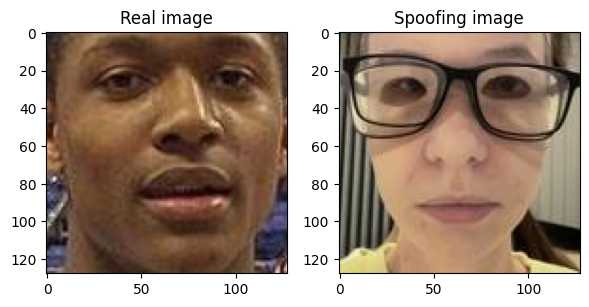

In [8]:
test_dir = 'PATH TO DIRECTORY WITH NEW IMAGES FOR TESTING'
test_real_images = sorted(glob(test_dir + 'live/*.jpg'))

test_spoof_images = sorted(glob(test_dir + 'spoof/*.jpg'))

# Visualization of one pair of images from the test dataset
print(f'{len(test_real_images)} real images for testing')
print(f'{len(test_spoof_images)} spoof images for testing')

test_real = plt.imread(test_real_images[0])
test_spoof = plt.imread(test_spoof_images[0])

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Real image')
plt.imshow(test_real)
plt.subplot(1,2,2)
plt.title('Spoofing image')
plt.imshow(test_spoof)
plt.tight_layout();

In [9]:
# Getting the prediction for the image of an alive person
transform = transforms.Compose([
    transforms.Resize((299,299) if model_name == 'inception' else (224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_real = Image.fromarray(test_real)
torch_real_image = transform(image_real).unsqueeze(0)
pred = model(torch_real_image)
pred

tensor([[1.0000e+00, 3.4332e-31]], grad_fn=<SoftmaxBackward0>)

In [10]:
# Getting the prediction for the image of a spoofing attack
image_spoof = Image.fromarray(test_spoof)
torch_spoof_image = transform(image_spoof).unsqueeze(0)
pred = model(torch_spoof_image)
pred

tensor([[1.0000e+00, 1.0359e-17]], grad_fn=<SoftmaxBackward0>)

In [11]:
# Obtaining the confusion matrix for the test dataset
labels = []
predictions = []
for path in tqdm(test_real_images, ncols=80):
    test = plt.imread(path)
    image = Image.fromarray(test)
    torch_image = transform(image).unsqueeze(0)
    pred = model(torch_image).detach().numpy()
    predictions.append(pred.argmax())
    labels.append(0)

for path in tqdm(test_spoof_images, ncols=80):
    test = plt.imread(path)
    image = Image.fromarray(test)
    torch_image = transform(image).unsqueeze(0)
    pred = model(torch_image).detach().numpy()
    predictions.append(pred.argmax())
    labels.append(1)

confusion_matrix(labels, predictions)

100%|█████████████████████████████████████████| 506/506 [00:16<00:00, 30.62it/s]


array([[187,   1],
       [450,  56]])